### Deliverable 2 – Data Analysis Template

Explore and present analysis of the dataset using relevant tools discussed in the course (R, SQL, Python, Tableau, etc.):

1)	Prepare relevant descriptive statistics and visualizations for selected data items (i.e., you don’t need to analyze all
the items in the dataset if there is a very large number of them):

    a)	Prepare and include appropriate statistics and visualizations, for example:
        i) Scatterplots, boxplots, correlation analyses, regression analyses, hypothesis tests
        ii) Include an SQL schema for the data, and demonstrate a few basic SQL-based queries of the dataset
        
    b)	Graphics and tables must follow good visualization practices discussed in the course
        i) See Chapter 4 of the textbook for guidance
        
2)	Interpret the results; what conclusions can be supported?

    a)	This should reflect answers to the specific questions specified above
    b)	Describe the value obtained from the study
    c)	Include explanations of any technical terms relevant to the project domain


##### Project deliverable 2 is worth 25% of your overall project assignment grade. It is due by Sunday, 11:59 pm ET, at the end of week 7.

#### Reading Data

The Virginia Capital Trail Usage data was accessed through the Virginia Open Data Portal API. Two datasets were initially pulled, one with usage of trail data by hour for different usage counter locations (2016-2020) and another with the coordinates of the usage counter locations. 

In [18]:
# Read in the Data from https://data.virginia.gov/
import pandas as pd
from sodapy import Socrata

# Authenticated client:
client = Socrata('data.virginia.gov',
                 'jN2rJlZ2GTuwAh26szWnIx2cL',
                 username="wpriddy@gmu.edu",
                 password="SECRET")

# Limit greater than number of rows to get complete data
results_usage = client.get("ryby-ewy7", limit=45000)

#Counter Location
counter_loc = client.get("yv9b-k8uu", limit=10)

#### Clean up the Counter Location Data

In [19]:
# Parse JSON file to get relevant data points: lat, long, and counter name
counter_dataframe = pd.DataFrame({i['counters']: i['geocoded_column']['coordinates'] for i in counter_loc}).T.reset_index()

# Rename columns
counter_dataframe.columns = ['Counter', 'long', 'lat']

# Counter location name mapping dictionary
counter_names = {'Capital Trail - 1 Almond Creek':'almond_creek',
                 'Capital Trail - 3 Willis Church':'willis_church', 
                 'Capital Trail - 2 Four Mile Creek':'four_mile', 
                 'Capital Trail - 4 Herring Creek': 'herring_creek', 
                 'Capital Trail - 7 Chickahominy River':'chickahominy', 
                 'Capital Trail - Greenspring':'greenspring'}

# Map names to Counter DataFrame
counter_dataframe['name_map'] = counter_dataframe['Counter'].map(counter_names)

# Create Hash Map for Lat/Long 
lat_map = {name: counter_dataframe.loc[counter_dataframe['name_map'] == name]['lat'].reset_index(drop=True)[0] 
           for name in counter_names.values()}

long_map = {name: counter_dataframe.loc[counter_dataframe['name_map'] == name]['long'].reset_index(drop=True)[0]
           for name in counter_names.values()}


#### Clean up Trail Usage Data

In [20]:
# Read API JSON output into pd.DataFrame
usage_data = pd.DataFrame.from_records(results_usage)

# Convert columns to numeric
for i in usage_data.columns:
    if i != 'date':
        usage_data[i] = pd.to_numeric(usage_data[i])

# Convert date from str to datetime
usage_data['date'] = pd.to_datetime(usage_data['date'])

# Aggregate multiple counters from similar locations to one counter
for counter_name in list(counter_names.values()):
    usage_data[counter_name] = usage_data[[col for col in usage_data.columns if counter_name in col]].sum(axis=1, skipna=False)

# Rename columns
usage_data = usage_data[['date'] + list(counter_names.values())]

#### Data Cleaning Continued

Exemplified by the missing data in the plot below, this real world data has gaps at different times for each station. Due to the lack of consistent data, only the years 2018 and 2019 were kept for analysis. That time period had no null values for any station.

<AxesSubplot:title={'center':'Null Values Example'}, xlabel='date', ylabel='Number of People At Four_Mile'>

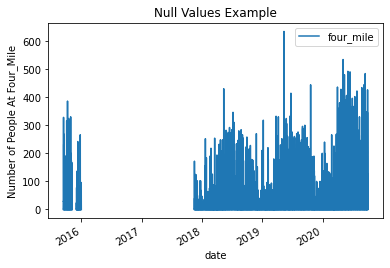

In [21]:
usage_data.plot(x = 'date', 
                y = (null_counter:='four_mile'), 
                title='Null Values Example', 
                ylabel=f'Number of People At {null_counter.title()}'
               )

In [22]:
# Drop Rows with Null Values
usage_data = usage_data.dropna(how='any')

# Drop incomplete years so the month analysis wont be off
usage_data = usage_data[(usage_data['date'] >= '2018')*(usage_data.date <'2020')]

# Melt Data Frame for machine readability
usage_data = pd.melt(usage_data, 
                     id_vars = ['date'], 
                     value_vars=list(counter_names.values()), 
                     var_name='counter', 
                     value_name='usage')

# Add year, month, day, hour columns for analysis
usage_data['year'] = usage_data['date'].apply(lambda x: x.year)

usage_data['month'] = usage_data['date'].apply(lambda x: x.month)

usage_data['hour'] = usage_data['date'].apply(lambda x: x.hour)

usage_data['day_name'], usage_data['day_number'] = usage_data['date'].dt.day_name(), usage_data['date'].dt.dayofweek

# Map Latitude and Longitude to DataFrame
usage_data['lat'] = usage_data['counter'].map(lat_map)

usage_data['long'] = usage_data['counter'].map(long_map)

# Create a map for later data merging
usage_data['map'] = usage_data['date'].apply(lambda x: '-'.join([str(x.year), str(x.month), str(x.day)]))

# View Usage Data
usage_data.head()

,date,counter,usage,year,month,hour,day_name,day_number,lat,long,map
0,2018-01-01 00:00:00,almond_creek,0.0,2018,1,0,Monday,0,37.50754,-77.413864,2018-1-1
1,2018-01-01 01:00:00,almond_creek,0.0,2018,1,1,Monday,0,37.50754,-77.413864,2018-1-1
2,2018-01-01 02:00:00,almond_creek,0.0,2018,1,2,Monday,0,37.50754,-77.413864,2018-1-1
3,2018-01-01 03:00:00,almond_creek,0.0,2018,1,3,Monday,0,37.50754,-77.413864,2018-1-1
4,2018-01-01 04:00:00,almond_creek,0.0,2018,1,4,Monday,0,37.50754,-77.413864,2018-1-1


#### Get SQL SCHEMA and run basic queries

In [23]:
print(pd.io.sql.get_schema(usage_data, 'data'))

CREATE TABLE "data" (
"date" TIMESTAMP,
  "counter" TEXT,
  "usage" REAL,
  "year" INTEGER,
  "month" INTEGER,
  "hour" INTEGER,
  "day_name" TEXT,
  "day_number" INTEGER,
  "lat" REAL,
  "long" REAL,
  "map" TEXT
)


In [24]:
# Get all Data from the year 2018
data_2018 = usage_data.query('year == 2018')

# Get all Data from the year 2018 and counter location almond_creek
almost_creek_2018 = usage_data.query('year == 2018 & counter == "almond_creek"')

#### Additional Data for Analysis

To help explain the variance of usage on the Capital Trail, weather data was accessed from the National Oceanic And Atmospheric Administration (NOAA) API. Only daily data was found for weather - not hourly like the trail usage data.

In [25]:
import requests as r

# Create Authentication 
headers = {'User-Agent': 'Test (your@email.com)',
    'accept': 'application/json',
    'token': 'FtwgVooCZMyociHKapqAWuQDqthqZUPv'
    }

# Empty Dictionary to Store API results
data_dict = {}

# Variable to use for Offset API calls
counter = 0

# Get Data For the 2 years we have of Capital Trail Usage
for i in ['2018', '2019']:
    for j in range(0, 6):
        data_dict[i + str(j)] = pd.DataFrame(r.get('https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&units=standard&locationid=ZIP:23250&startdate={}-01-01&enddate={}-12-01&limit=1000&offset={}'.format(i, i, counter), headers=headers).json()['results'])
        counter += 1000
    counter = 0

# Concatenate JSON results to pd.DataFrame
weather_data = pd.concat(data_dict.values()).drop_duplicates()

# Map for datatype names
dtype_dict = {'RHAV': 'Average Relative Humidity',
              'PRCP': 'Precipitation', 
              'TAVG': 'Average Temperature'}

# Map datatype names to weather_data
weather_data['datatype_name'] = weather_data['datatype'].map(dtype_dict)

# Convert date to datetime
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Create a map to join this data with the trail usage data
weather_data['map'] = weather_data['date'].apply(lambda x: '-'.join([str(x.year), str(x.month), str(x.day)]))

# Drop irrelevant variables from weather data to focus on main weather indicators
weather_data = weather_data[~weather_data.datatype_name.isna()][['date', 'value', 'datatype_name', 'map']].reset_index(drop=True)

# Reshape dataset to get ready to merge
weather_data = weather_data.pivot(index='date', columns='datatype_name', values='value').reset_index()

weather_data.head()

datatype_name,date,Average Relative Humidity,Average Temperature,Precipitation
0,2018-02-28,74.0,49.0,0.00
1,2018-03-01,100.0,53.0,0.18
2,2018-03-02,62.0,51.0,0.00
3,2018-03-03,53.0,45.0,0.00
4,2018-03-04,62.0,44.0,0.00


#### Merging the data

In [26]:
# Make a Copy so we can use the usage data on its own
merge_data = usage_data.copy(deep=True)

# Convert datetime to exclude hour
merge_data['date'] = pd.to_datetime(merge_data.date.dt.date)

# Group by Days
merge_data = merge_data.groupby('date').sum()['usage'].reset_index()

# Merge & Drop Null for Statistical Analysis
data_full = merge_data.merge(weather_data, how='left', on='date')

data_full = data_full.dropna(how='any')

#### Dataset Size

In [27]:
from sys import getsizeof

print("Dataset Size:", round(getsizeof(usage_data)/10**6, 2), 'MB')

Dataset Size: 18.21 MB


### 1. Exploratory Analysis

In [28]:
import plotly.express as px

# Group Data for Vizualiation
bubble_scatter_on_map = usage_data.groupby('counter').sum()[['usage', 'lat', 'long']].reset_index()

# Remap coordinates since groupby changed them
bubble_scatter_on_map['lat'] = bubble_scatter_on_map['counter'].map(lat_map)
bubble_scatter_on_map['long'] = bubble_scatter_on_map['counter'].map(long_map)

fig = px.scatter_mapbox(bubble_scatter_on_map,
                         lat='lat', 
                         lon='long',
                         size='usage', 
                         color='usage',
                         hover_data={'counter': True, 'long':False, 'lat':False})

fig.update_layout(mapbox_style='carto-positron', 
                   title={'text': 'Overall Usage of the Capital Trail in 2018-2019','x':0.5}, 
                   margin = {'b': 20, 'l':20, 'r':20, 't':37})

fig.show()

The majority of Capital Trail usage occurs in Richmond (Almond_Creek) and Williamsburg (Greenspring). Both areas have the largest population density therefore are more heavily trafficked. 

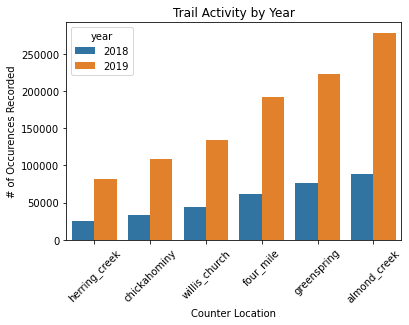

In [29]:
import seaborn as sns

# Get data ready for visualization
bar_with_categories = usage_data.groupby(['counter', 'year']).sum()[['usage', 'lat', 'long']].reset_index()

usage_by_year = sns.barplot(data = bar_with_categories.sort_values('usage'), x='counter', y='usage', hue='year')

usage_by_year.set_title('Trail Activity by Year')
usage_by_year.set_ylabel('# of Occurences Recorded')
usage_by_year.set_xlabel('Counter Location')
usage_by_year.tick_params(axis='x', rotation=45)

Seen in a different format, Williamsburg (Greenspring) and Richmond (Almond Creek) have the most occurences recorded. 2018 had substantially lower numbers of occurences than 2019. 

<AxesSubplot:title={'center':'Trail Activity by Month'}, xlabel='month', ylabel='# of Occurences Recorded'>

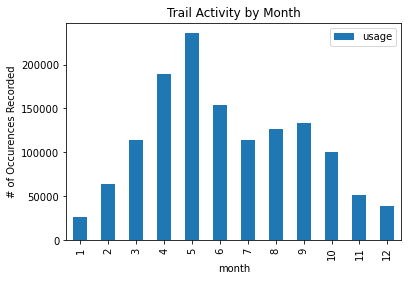

In [30]:
# Get data ready for visualization
month_viz = usage_data.groupby(['month']).sum()['usage'].reset_index().sort_values('month')

month_viz.plot(kind='bar', x='month', y='usage', title='Trail Activity by Month', ylabel='# of Occurences Recorded')

Late spring and early summer (May and June) are the most popular months to visit the Capital Trail. The least popular months are in the winter (December and January). 

<AxesSubplot:title={'center':'Trail Activity by Day'}, xlabel='day_name', ylabel='# of Occurences Recorded'>

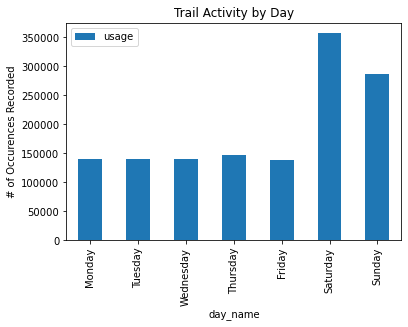

In [31]:
# Get data ready for visualization
day_of_week = usage_data.groupby(['day_name', 'day_number']).sum()['usage'].reset_index().sort_values('day_number')

day_of_week.plot(kind='bar', x='day_name', y='usage', title='Trail Activity by Day', ylabel='# of Occurences Recorded')

Weekends (Saturday and Sunday) are the most popular time for the trail to be used. During the work week, the level of usage is consistent. 

<AxesSubplot:title={'center':'Trail Activity by Hour'}, xlabel='hour', ylabel='# of Occurences Recorded'>

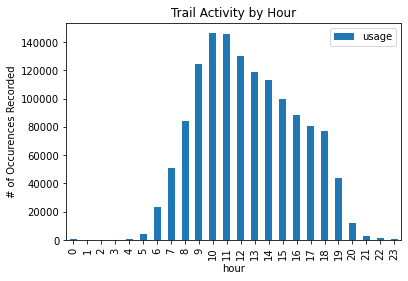

In [32]:
# Get data ready for visualization
hour_viz = usage_data.groupby(['hour']).sum()['usage'].reset_index().sort_values('hour')

hour_viz.plot(kind='bar', x='hour', y='usage', title='Trail Activity by Hour', ylabel='# of Occurences Recorded')

The most popular times to visit the Capital Trail are between 9am - 5pm. 

Text(0.5, 1.0, 'Correlation Map of Merged Data')

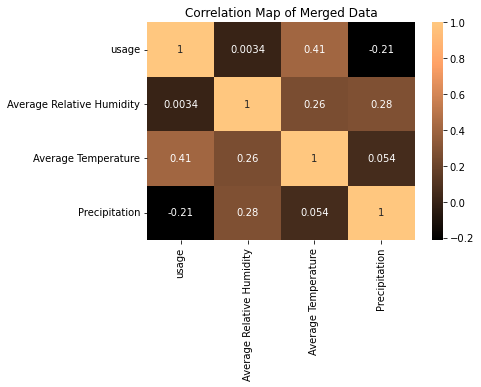

In [33]:
heatmap = sns.heatmap(data_full.corr(), cmap='copper', annot=True)
heatmap.set_title('Correlation Map of Merged Data')

Capital Trail usage has the highest positive correlation (0.41) with the average temperature. This means that the higher the temperature the more activity the Capital Trail sees. Capital Trail usage has the highest negative correlation (-0.21) with the amount of precipitation. Therefore more precipitation means less activity on the Capital Trail.

In [34]:
import statsmodels.api as sm

# Create the Model
x = sm.add_constant(data_full[['Precipitation', 'Average Temperature']])
 
# Fit & Predict
model = sm.OLS(data_full['usage'], x).fit()
predictions = model.predict() 
 
# View Results
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  usage   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     52.26
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           1.01e-20
Time:                        21:05:18   Log-Likelihood:                -3383.1
No. Observations:                 374   AIC:                             6772.
Df Residuals:                     371   BIC:                             6784.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -918.9292    

C:\Users\wpriddy\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



**R$^2$:**

The R$^2$ of this multiple variable linear regression is 0.222. The adjusted R$^2$ is 0.215 meaning there no erroneous variables skewing the analysis.  While a seemingly lower R$^2$, this says that the weather accounts for 22% of the variance of Capital Trail usage. 

If population were added to this regression, my assumption would be that the R$^2$ and adjusted R$^2$ would increase substantially.

**Coefficifients & p values:**

Precipitation is statistically significant at the 99% confidence level. This indicates that an increase of one unit of precipitation results in a decrease of approximately 1398 less occurences on the Capital Trail. 

Average temperature is also statistically significant at the 99% confidence level. This indicates an increase in one unit of temperature results in approximately 67 more occurences on the Capital Trail. 

### 2. Interpretation of Results

The result of this research provides insight into the driving factors of Capital Trail usage. Having insights into what causes trail usage could help the Virginia Capital Trail Foundation indentify: areas which will need more repairs, what time and days are best for trail maintenance, what months might be best for maintenance, the style of user on the trail (thru-biker/hiker vs section-biker/hiker), and how the weather impacts trail usage. 

#### Citations
K. Jordan. Capital Trail Usage by Hour, Virginia Open Data Portal. September 29, 2022

https://data.virginia.gov/Datathon-2020/Capital-Trail-Usage-by-Hour/ryby-ewy7

K. Jordan. Capital Trail Counters - geolocation, Virginia Open Data Portal. October 2, 2022

https://data.virginia.gov/Datathon-2020/Capital-Trail-Counters-geolocation/yv9b-k8uu

NOAA Datasets. Average Daily Weather. October 5th, 2022

https://www.ncdc.noaa.gov/cdo-web/webservices/v2